# Getting Started with `FEEMS` & `FEEMSmix`

This notebook illustrates a minimal example of how to run `FEEMS` and `FEEMSmix` on a dataset of North American gray wolves published in [Schweizer _et al_ 2015](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW).

## Imports

First we import the required packages and `FEEMS`:

In [53]:
# base
import numpy as np
# import pkg_resources -> deprecated
from importlib import resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs, cov_to_dist
from feems.objective import comp_mats
from feems.viz import draw_FEEMSmix_fit, plot_FEEMSmix_result
from feems import SpatialGraph, Objective, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Data

Note we have packaged this example dataset in the `FEEMS` package and use the `importlib.resources` package to find the path of those files:

_Note: We were previously using `pkg_resources`, but that package has been deprecated (see [https://setuptools.pypa.io/en/latest/pkg_resources.html](https://setuptools.pypa.io/en/latest/pkg_resources.html))_

In [4]:
data_path = str(resources.files('feems') / 'data')

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [5]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 79.34it/s]

n_samples=111, n_snps=17729


As we can see we have 111 samples and 17,729 SNPs. For preparing the graph inputs to run `FEEMS` you have two options:

* Prepare your own input files
* Use the `FEEMS` function `prepare_graph_inputs` which intersects a discrete global grid (DGG) with the sample range

We'll show off the later option. We read the sample coordinates, coordinates of the outer polygon that defines the habitat of the sample and a discrete global grid file which has laid down a triangular grid that is uniformly spaced on earth. We then intersect this global grid with the outer file to define the graph that we use to optimize:

In [7]:
%%time
# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 4.91 s, sys: 57.4 ms, total: 4.97 s
Wall time: 4.98 s


Lets take a peek at each of these inputs:

In [5]:
outer[:5, ]

array([[-126.2547116,   48.6329086],
       [-127.5731488,   49.1817034],
       [-128.9351421,   50.1205781],
       [-130.2099765,   50.930738 ],
       [-131.8797738,   51.8900539]])

In [6]:
edges[:5, ]

array([[838, 839],
       [357, 386],
       [605, 637],
       [536, 537],
       [136, 158]])

In [7]:
grid[:5, ]

array([[-166.637,   59.732],
       [-166.585,   60.675],
       [-166.529,   61.623],
       [-168.75 ,   62.088],
       [-166.467,   62.576]])

## Setup the `SpatialGraph` object

We then setup the `SpatialGraph` object which is the core workhorse of `feems`. `SpatialGraph` specifies the graph, allele frequency data, and runs the optimizers to fit the edge weights of the graph:

In [54]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
CPU times: user 43.7 s, sys: 601 ms, total: 44.3 s
Wall time: 44.7 s


This might take a few minutes to construct at first b/c it initializing a number of graph matrices that are slow to build. First, before any fitting we'll visualize the graph and samples. Lets setup the projection we'll be using for this dataset:

_(We choose `AzimuthalEquidistant` here as it provides better scaling for regions closer to the poles. A good rule of thumb to follow here is to visually inspect the relative size of edges across the grid and check to make sure it is roughly similar. With `EquidistantConic`, we notice that edges closer to the poles are much wider than their more southern counterparts.)_

In [55]:
projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)

Now lets make a map of the sample coordinates, graph and observed nodes:

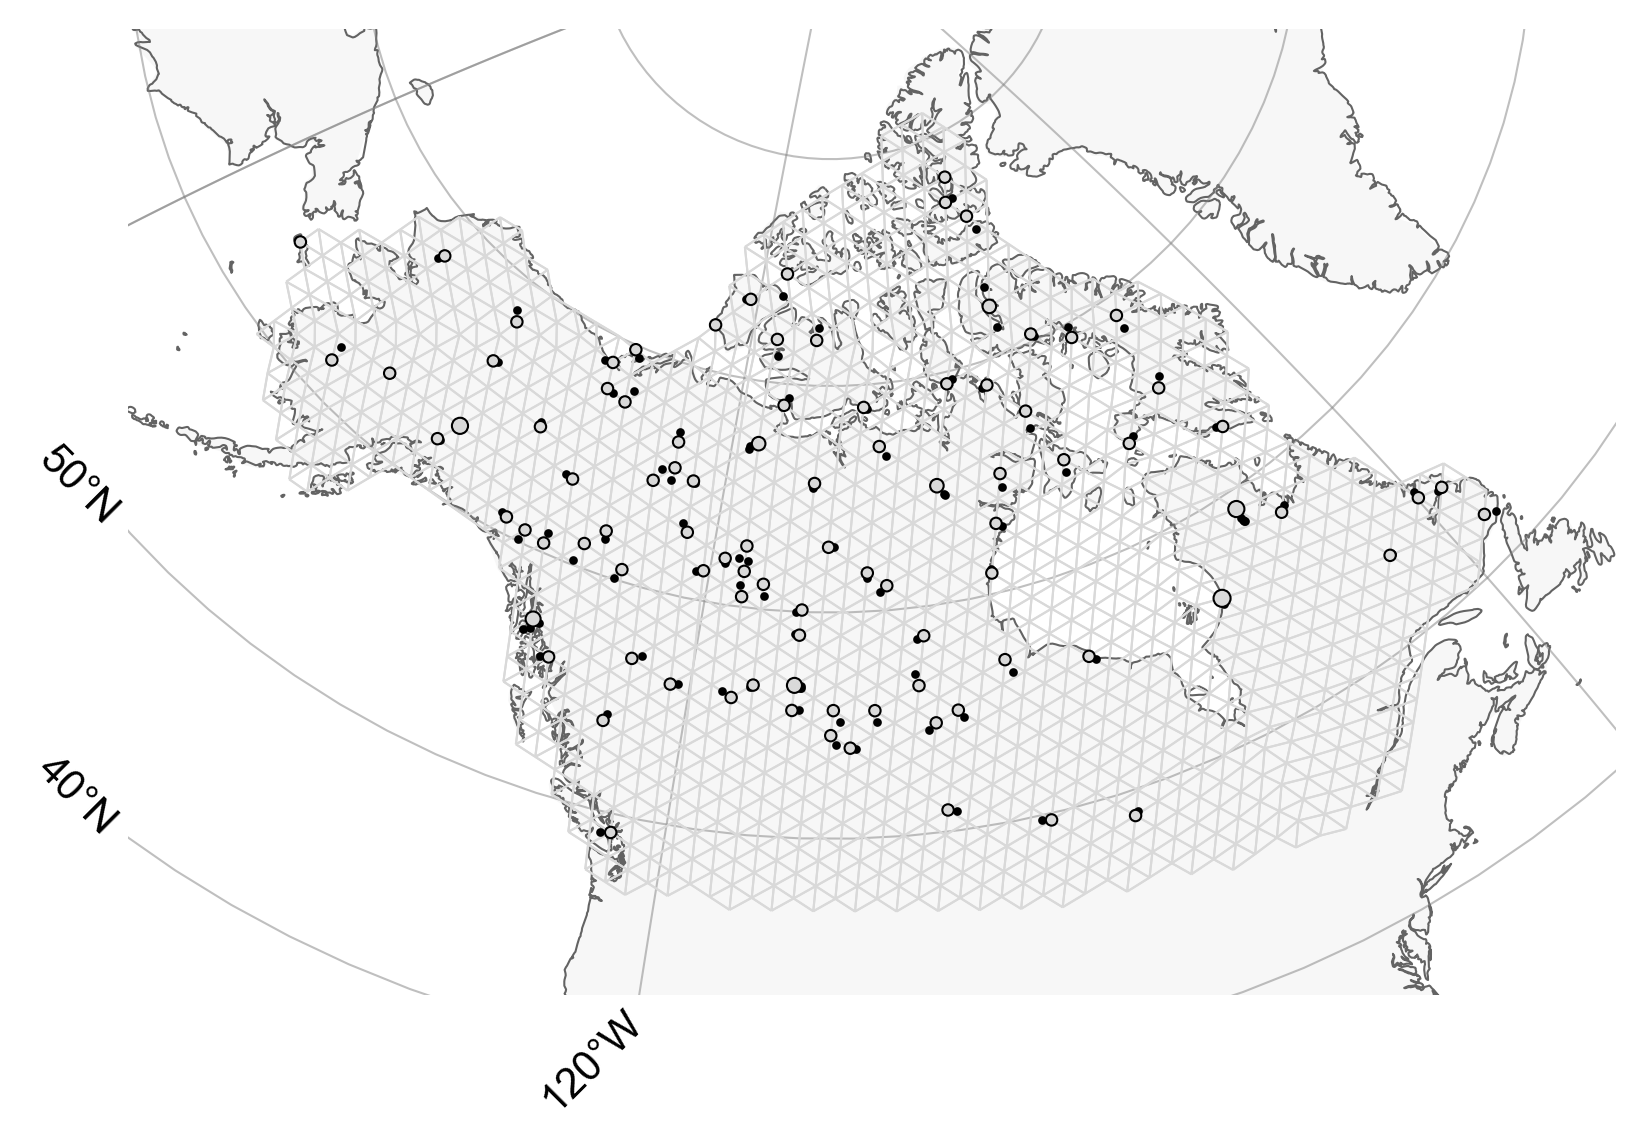

In [35]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(latlong=True)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

The black points are the observed locations for each sample and the gray points show the nodes that samples were assigned to. The gray lines represent the graph that will be fitted.

_Optional_: The latitude and longitude gridlines can be customized using `v.draw_map()`.

## Fit `FEEMS` (fixed variance across all nodes, default in _v1.0_)

Next we fit a the `FEEMS` model where we allow a weight to be estimated for every edge, which is encoded in a large adjacency matrix $\mathbf{W}$, while encouraging nearby edges to be smooth. We initialize at the fit from the null model and fix the estimate of the residual variance for the more complex optimization:

In [32]:
%%time
sp_graph.fit(lamb = 2.0, optimize_q=None)

CPU times: user 6.05 s, sys: 298 ms, total: 6.35 s
Wall time: 1.9 s


Now we can visualize the weighted graph:

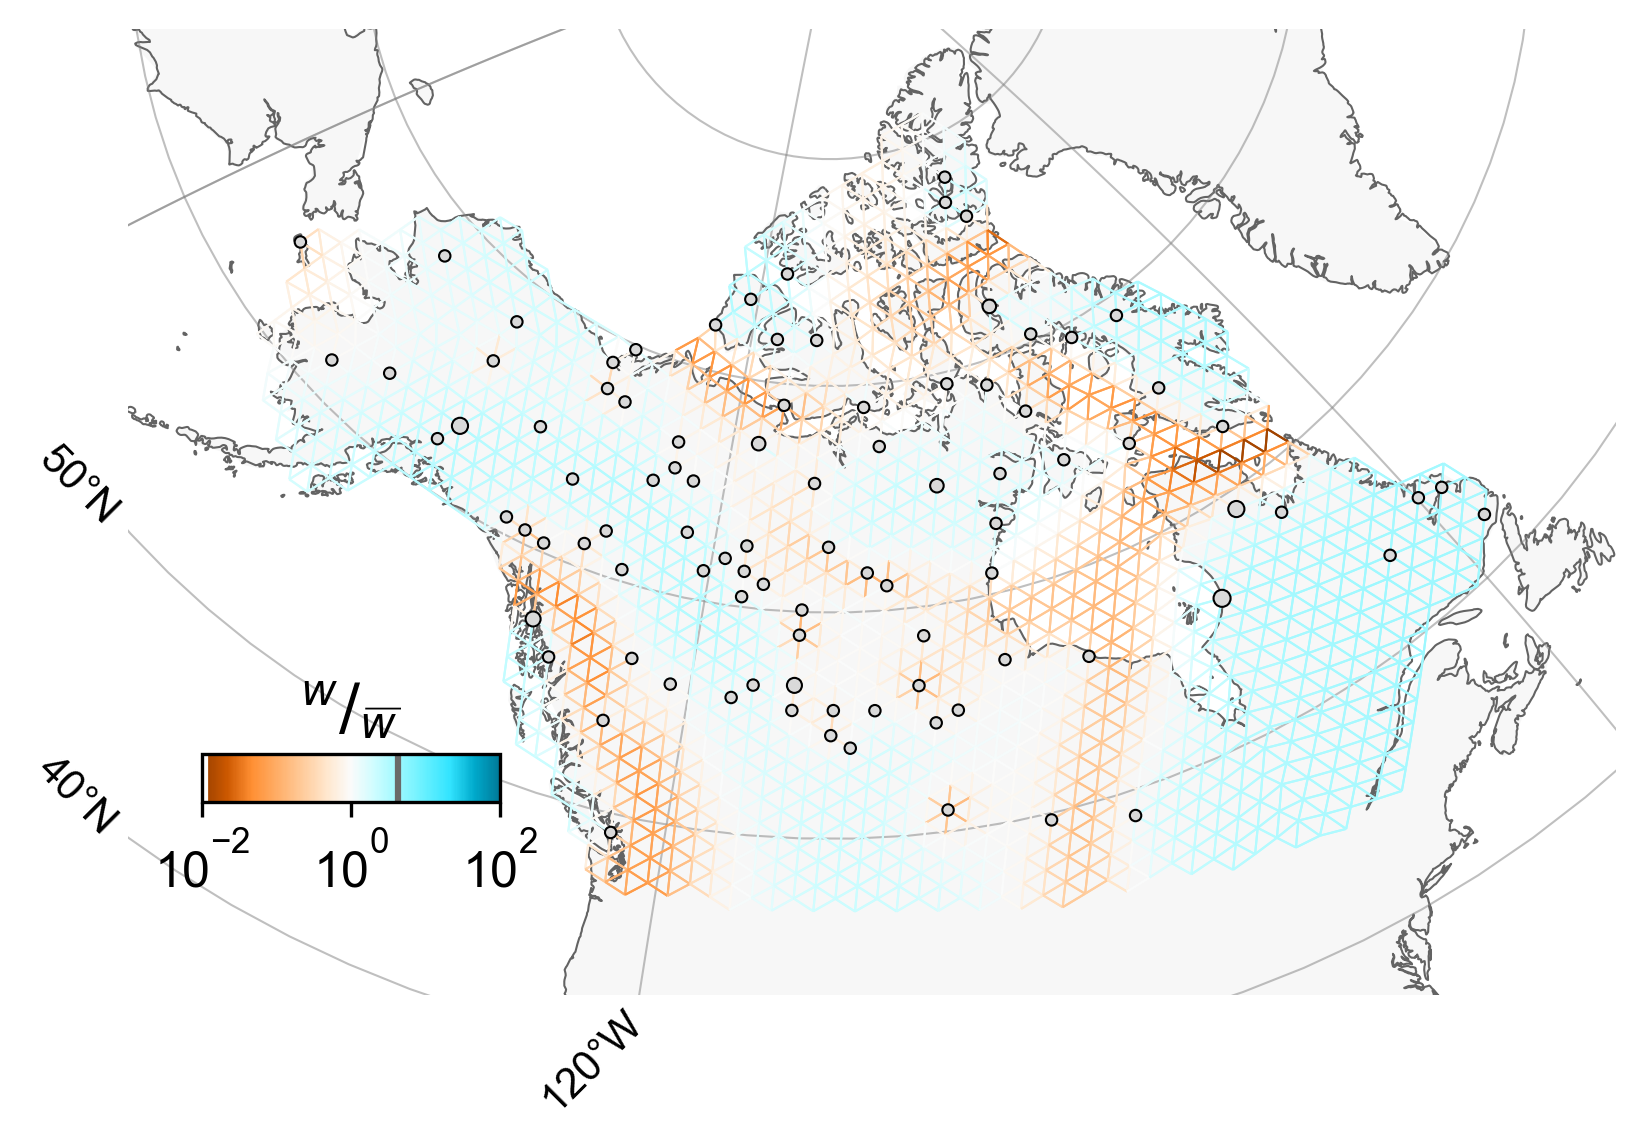

In [33]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

We can also visualize the fit of the model to the observed pairwise genetic distances from the genotype matrix. This is a way of diagnosing model fit.   

Text(0.5, 1.0, '$\\tt{FEEMS}$ fit with fixed node-specific variance')

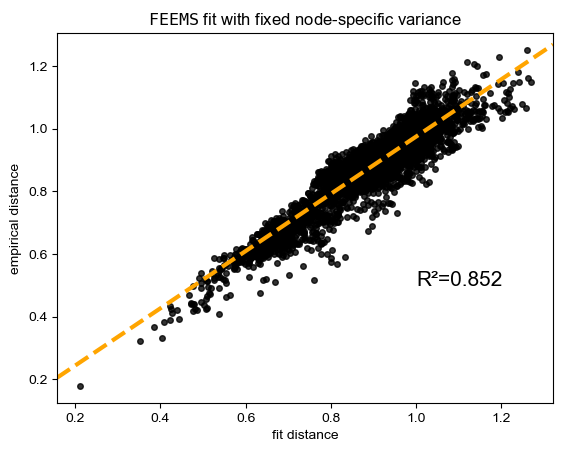

In [45]:
# creating an obj 
obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# computing distances matrice for fit (expected) vs empirical (observed) 
fit_cov, _, emp_cov = comp_mats(obj)
# subsetting matrices to arrays 
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]

# fitting a linear model to the observed distances
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params

plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4)
plt.axline((0.5,0.5*betahat+muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.text(1, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15)
plt.xlabel('fit distance'); plt.ylabel('empirical distance')
plt.title(r"$\tt{FEEMS}$ fit with fixed node-specific variance")

## Fit `FEEMS` (node-specific variance, default in _v2.0_)

In the latest version of `FEEMS`, we include a mode in which we fit separate variances for each sampled node in the graph (as opposed to a single fixed variance from above). This increases the number of parameters to be fit by the model by the number of sampled demes, which is $94$ in this case.  

As a result, we also have a new parameter called `lamb_q` which is a penalty on the node-specific variances (larger the value, the more similar the variances across the grid will be and vice versa). You could think of this as a slider to adjust for how differnt you expect the heterozygosities to be across the habitat.

In [27]:
%%time
sp_graph.fit(lamb = 2.0, lamb_q = 1.0, optimize_q = 'n-dim')

CPU times: user 37.3 s, sys: 5.03 s, total: 42.4 s
Wall time: 11.8 s


On my computer, this fit took over $\sim 4\times$ longer than the fixed node-specific variance fit. For this data set, we see that the two results are qualitatively very similar, save for a few minor differences:
1. the disappearance of the pinwheel-like patterns around sampled nodes (due to the felxibility from fitting node-specific parameters)
2. reduced effective migration around the islands in the northern part of the habitat  

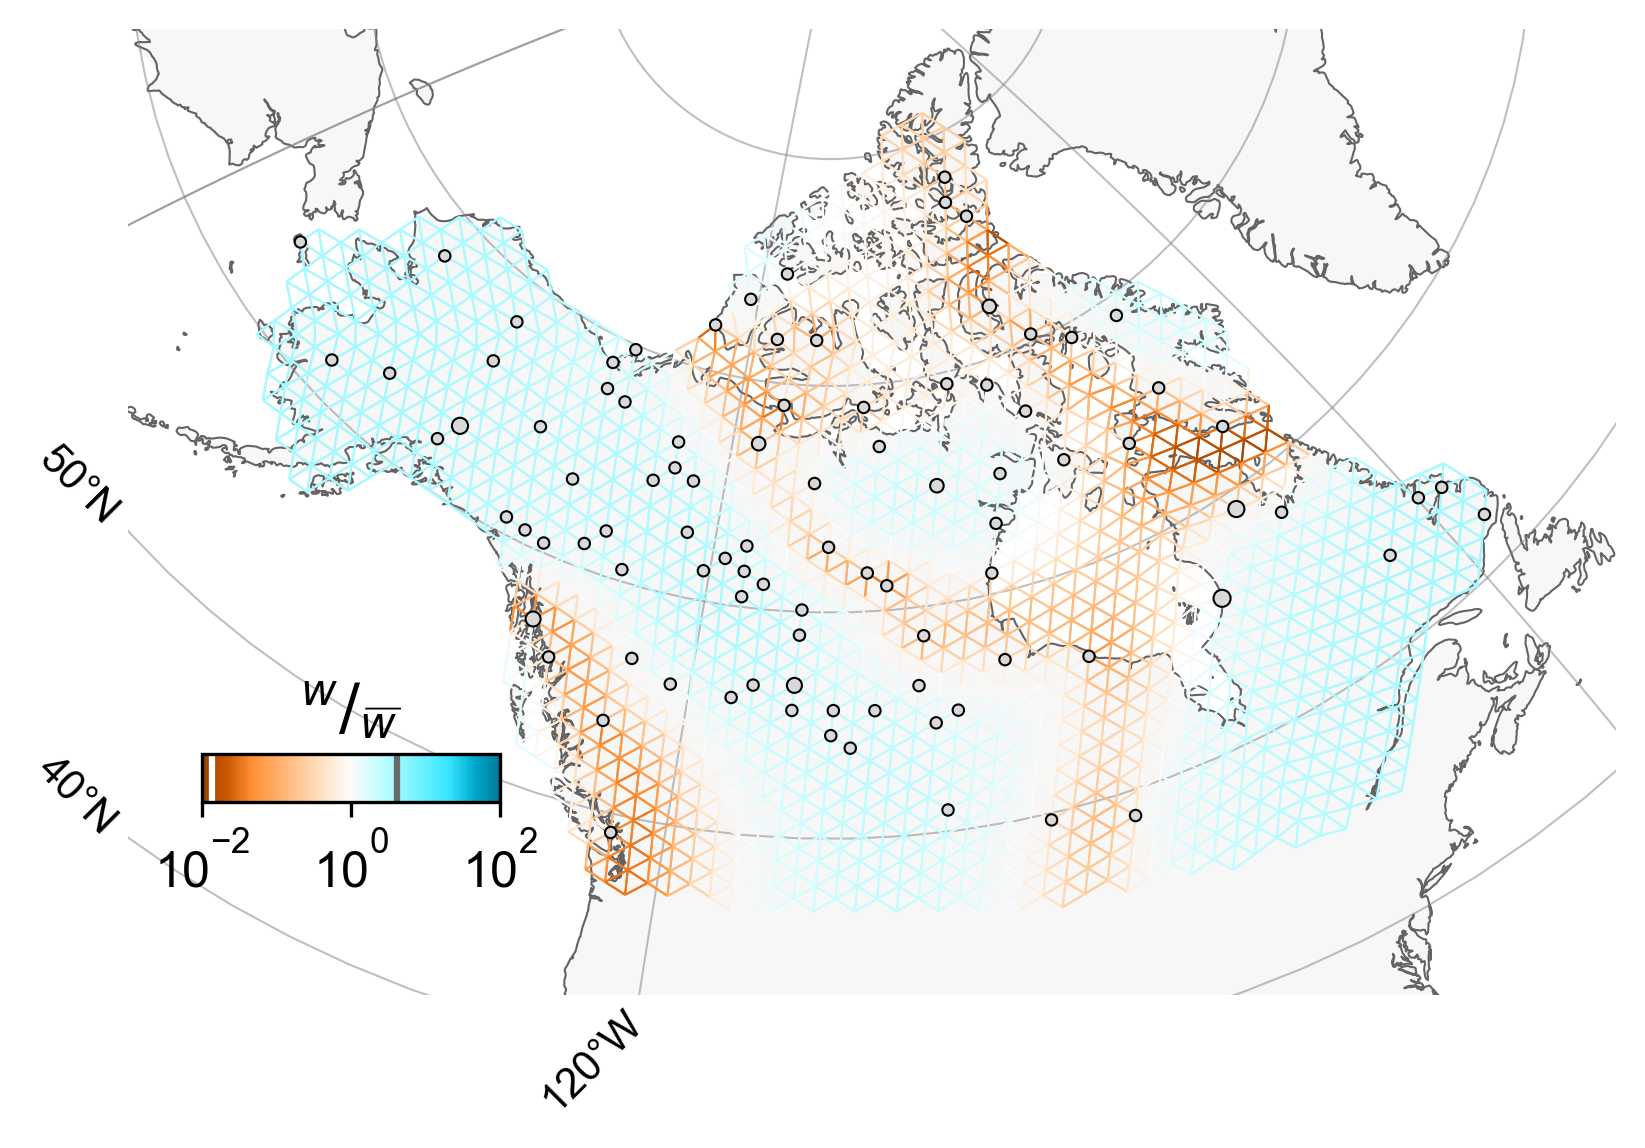

In [47]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

However, when we plot the diagnostic fit as before, and we find that this model does much better (higher $R^2$) when fitting the observed genetic distances between demes.  

Text(0.5, 1.0, '$\\tt{FEEMS}$ fit with estimated node-specific variances')

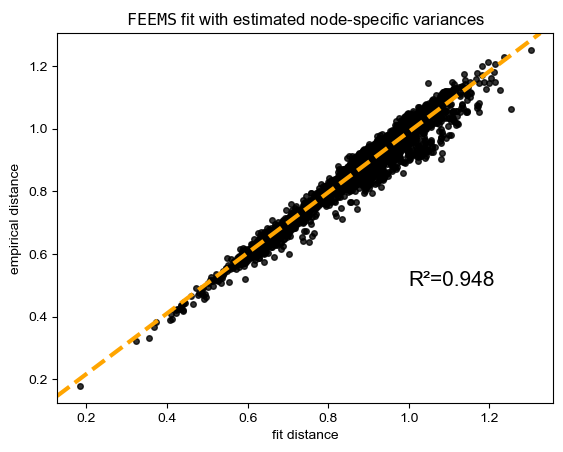

In [48]:
# creating an obj 
obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# computing distances matrice for fit (expected) vs empirical (observed) 
fit_cov, _, emp_cov = comp_mats(obj)
# subsetting matrices to arrays 
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]

# fitting a linear model to the observed distances
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params

plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4)
plt.axline((0.5,0.5*betahat+muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.text(1, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15)
plt.xlabel('fit distance'); plt.ylabel('empirical distance')
plt.title(r"$\tt{FEEMS}$ fit with estimated node-specific variances")

Great ... now we see our first `FEEMS` plot! We essentially provided these results interactively! For more interpretation of these figures and method please see the publication here: https://doi.org/10.7554/eLife.61927

# Fit `FEEMSmix` 

We will now go through the workflow of fitting long-range gene flow events over this baseline estimated migration surface found by `FEEMS`. This methodology is very similar to the idea of adding edges to an underlying topology in `TreeMix` (Pickrell & Pritchard 2012), with some additional flexibility. 

There are three modes in which this can be run. There will be a fair bit of overlap in the results amongst the approaches, so we recommend users to choose what is best for their data:

1. detect outliers on the baseline fit -> model each outlier _independently_ -> repeat until cycled through all outliers (recommended approach)
2. detect outliers on a baseline fit -> model largest outlier on the baseline graph -> find outliers on this new graph (baseline + long-range edge) -> repeat until no more outliers found (conservative approach)
3. model long-range gene flow to any user-specified deme (wild west approach)

With all three modes, we employ a two-stage approach to finding the MLE location of the source and the admixture proportion. In the *first* stage, we separately fit an admixture proportion from `all` nodes (or some user-specified set of nodes) to a particular destination deme (assuming fixed weights and variances). In the *second* stage, we take the `top` (percent or number) nodes from the *first* stage (based on the log-likelihood) and refit the admixture proportions in a _joint_ manner with the weights and variances. This *second* stage is a costly procedure so we don't employ it on _all_ the nodes in the graph, however, we've found equivalent results with both schemes in the simulation (so we let users decide the value for `top`, default: $5\%$ or $0.05$).  

### Detecting outliers on baseline graph

We are not too concerned with a higher FDR level as we've noticed that, typically, in the presence of false positives, the estimated admixture proportions tend to be small (see example at the very end of this notebook for deme _445_). 

In [295]:
# choose a specified FDR level 
outliers_df = sp_graph.extract_outliers(fdr=0.3)

Using a FDR of 0.3: 160 outlier deme pairs found
Putative destination demes: [ 980  207  180  621 1206  187  815  189  350  390  402  585  668  719
  747  910]


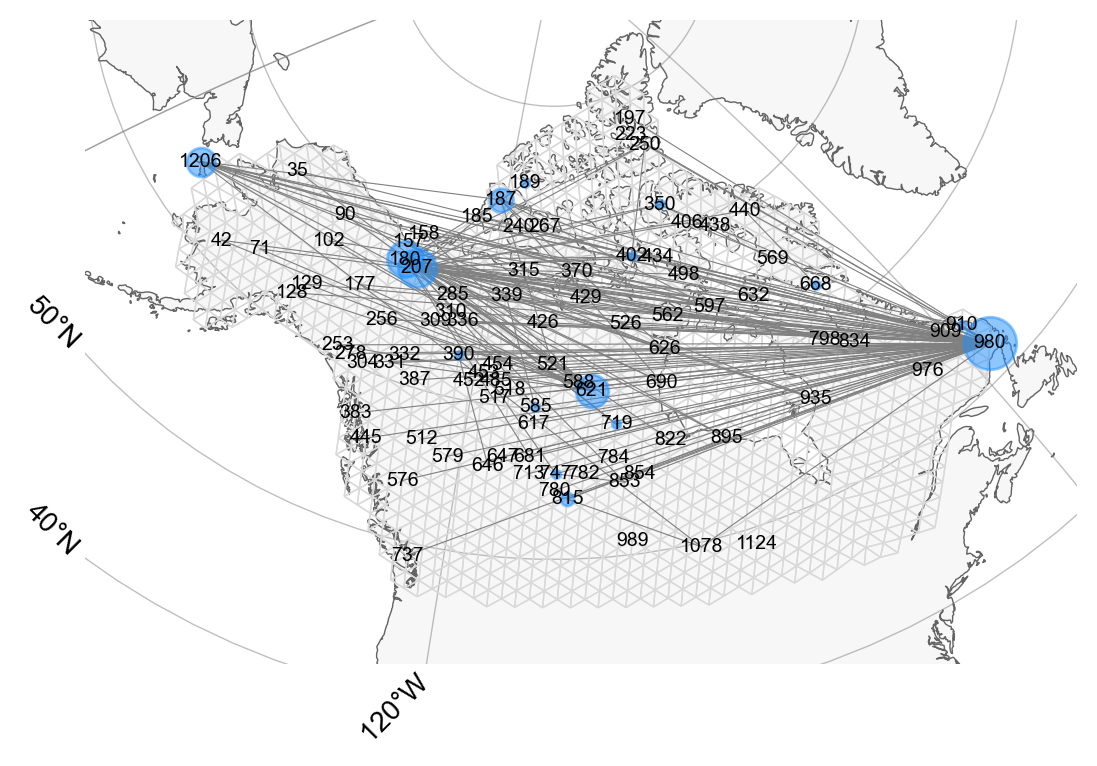

In [296]:
# visualizing the outlier demes on the map
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); v.draw_edges(use_weights=False)
# ~NEW~ function
v.draw_outliers(outliers_df)
# using deme IDs since all results will be represented with these numbers
v.draw_obs_nodes(use_ids=True)

#### Outliers with a different baseline fit

The identity of the outliers will change with different values of `lamb` and `lamb_q`, though there will be some overlap across this spectrum. We urge users to investigate this behavior, but as a starting point, we recommend users to start with the cross-validated values as chosen by the procedure in [cross-validation.ipynb](https://github.com/NovembreLab/feems/blob/main/docsrc/notebooks/cross-validation.ipynb).

Here, we show the outliers with a different value of `lamb=20` and `lamb_q=0.01`.  We see that some outlier demes (_980, 621, 207, 180, 1206_) persist with the newer fit, but we also observe some newer demes (_668, 315, 350_) pop up. 

Using a FDR of 0.3: 64 outlier deme pairs found
Putative destination demes: [ 980  621  207 1206  180  668  737  185  315  350  815 1124]


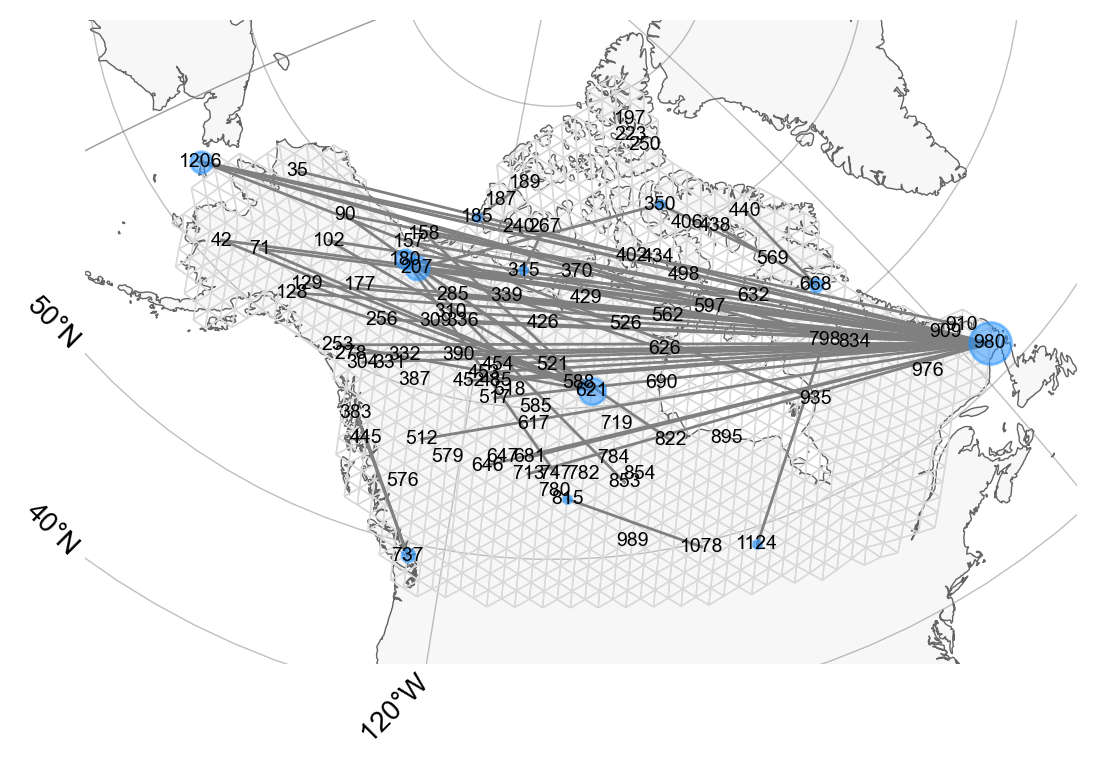

In [30]:
sp_graph.fit(lamb = 20.0, lamb_q = 0.01, optimize_q = 'n-dim')

# etract outliers 
outliers_df = sp_graph.extract_outliers(fdr=0.3, verbose=True)

# visualizing the outlier demes on the map
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); v.draw_edges(use_weights=False)
v.draw_outliers(outliers_df)
v.draw_obs_nodes(use_ids=True)

## Option 1 (`independent_fit`)

The method found $15$ unique putative destination demes (ordered above based on how many times a particular deme is implicated as an outlier). We can fit a long-range gene flow event to each deme independently, but for illustrative purposes, we will stop after fitting $4$ edges. 

We also highlight two different mechanisms for choosing the source demes of the long-range gene flow event:

- 'all': fit `FEEMSmix` over all demes in the graph (default)
- 'radius': fit `FEEMSmix` over all demes with a certain radius of a sampled source deme chosen from the outlier detection method above

For each deme, we will choose the `top=5` demes from the first stage above to fit in a joint fashion. This is merely for illustrative purposes, typically, a higher number or a percentage of demes is desirable. 

We also allow the user to exclude boundary nodes in the fitting procedure as we've noticed a few anomalies with estimates from these nodes in simulations. 

In [297]:
%%time
ind_results = sp_graph.independent_fit(
    outliers_df, 
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', # same parameters as before
    stop=4, # stop after 4 edges
    exclude_boundary=False, # exclude boundary nodes in fitting procedure
    top=5 # choosing the top 5 nodes to fit in a joint manner  
) 

Log-likelihood of initial fit: -34841.4


Fitting admixture edge to deme 980:
  Optimizing likelihood over 1047 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 5/5 most likely demes in the graph...done!

  MLE edge found from source 651 to destination 980 with strength 0.41

  Log-likelihood after adding MLE edge: -34474.0 (p-val = 8.03e-162)


Fitting admixture edge to deme 207:
  Optimizing likelihood over 1046 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 5/5 most likely demes in the graph...done!

  MLE edge found from source 395 to destination 207 with strength 0.89

  Log-likelihood after adding MLE edge: -34327.1 (p-val = 1.16e-225)


Fitting admixture edge to deme 180:
  Optimizing likelihood over 1046 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 5/5 most likely demes in the graph...done!

  MLE edge found from source 456 to destination 180 with strength 1.00

  Log-likelihoo

We can visualize these long-range edges and the diagnostic fits below. 

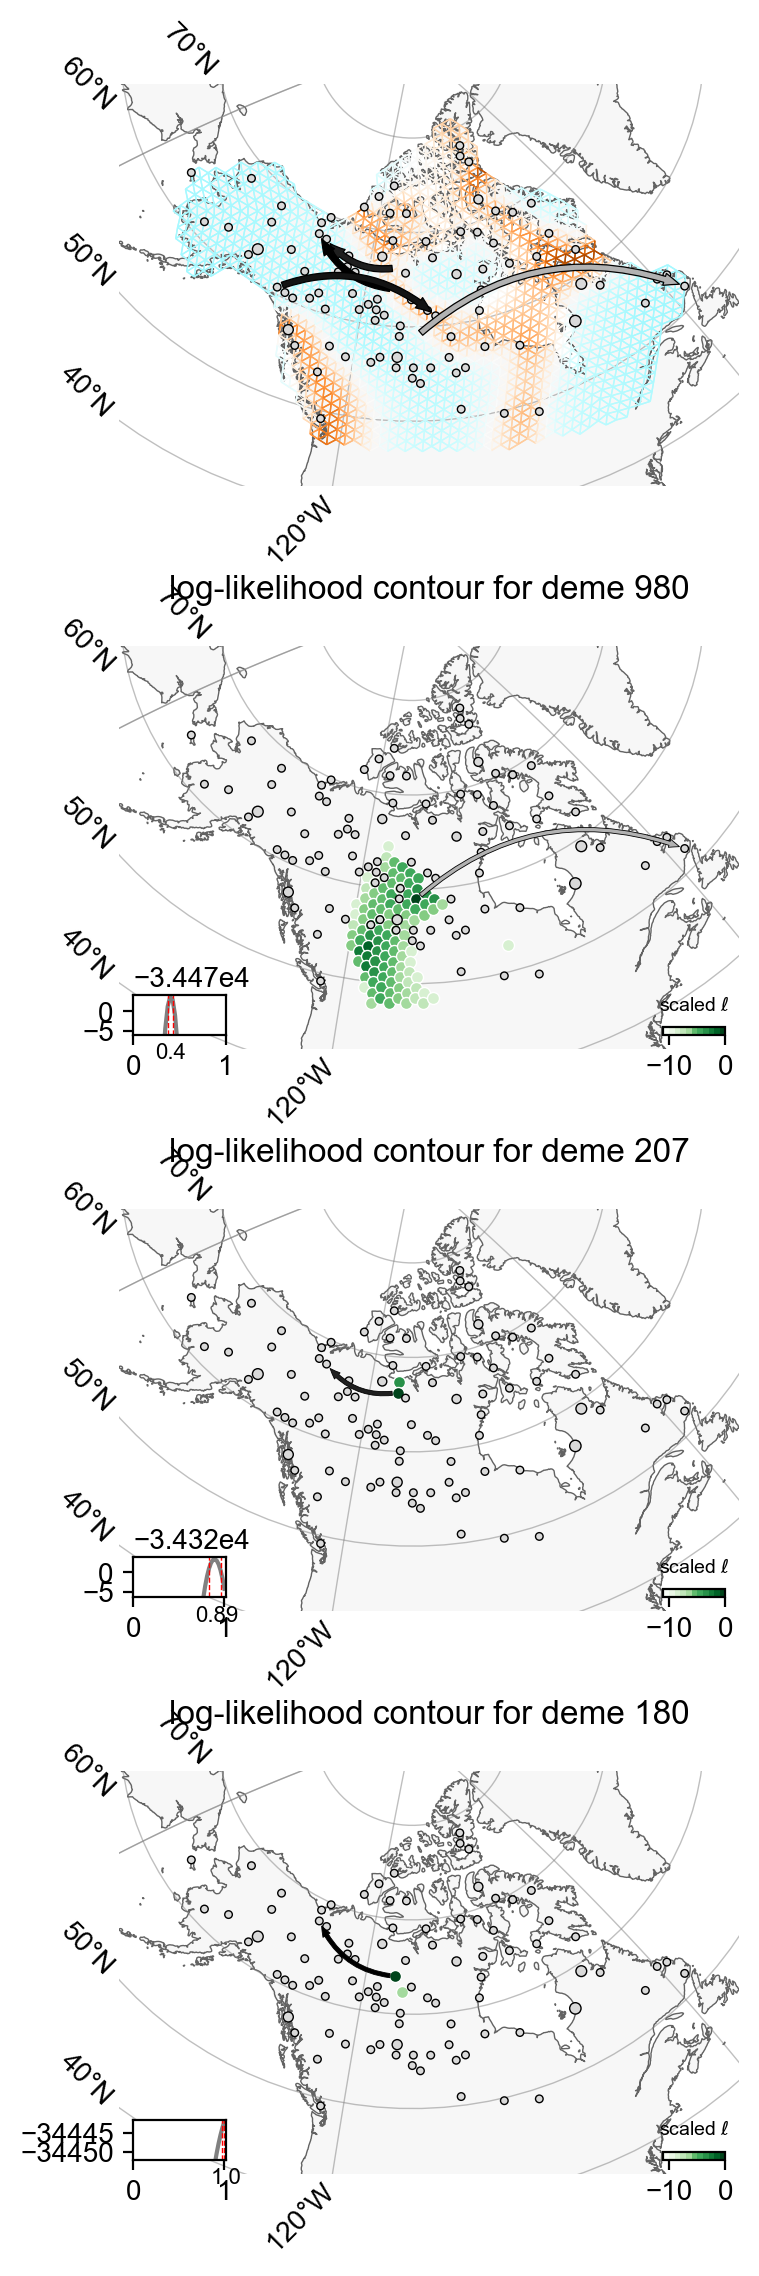

In [304]:
draw_FEEMSmix_fit(
    v, # Viz object created previously
    ind_results, # results from independet_fit above
    demes=3, # how many demes to plot (can also be index of deme IDs)
    magnifier=150, 
    draw_c_contour=False, # draw a contour of admix. prop.?
    draw_edges_mle=False, # draw edge weights after fitting long-range event?
    levels=-10, # how many log-likelihood units to include in plotting
    figsize=(4,14) # increase this size for less crowding 
)
# (optional) save figure in a certain location
# plt.savefig('~/Desktop/wolvesadmix_independent_fit.pdf')

We see that adding a long-range admixture edge to each deme not only significantly increases the likelihood of the model (based on the p-value printed above), but also increases the fit to the observed data by a few percentage points (based on the $R^2$ compared to the baseline).  

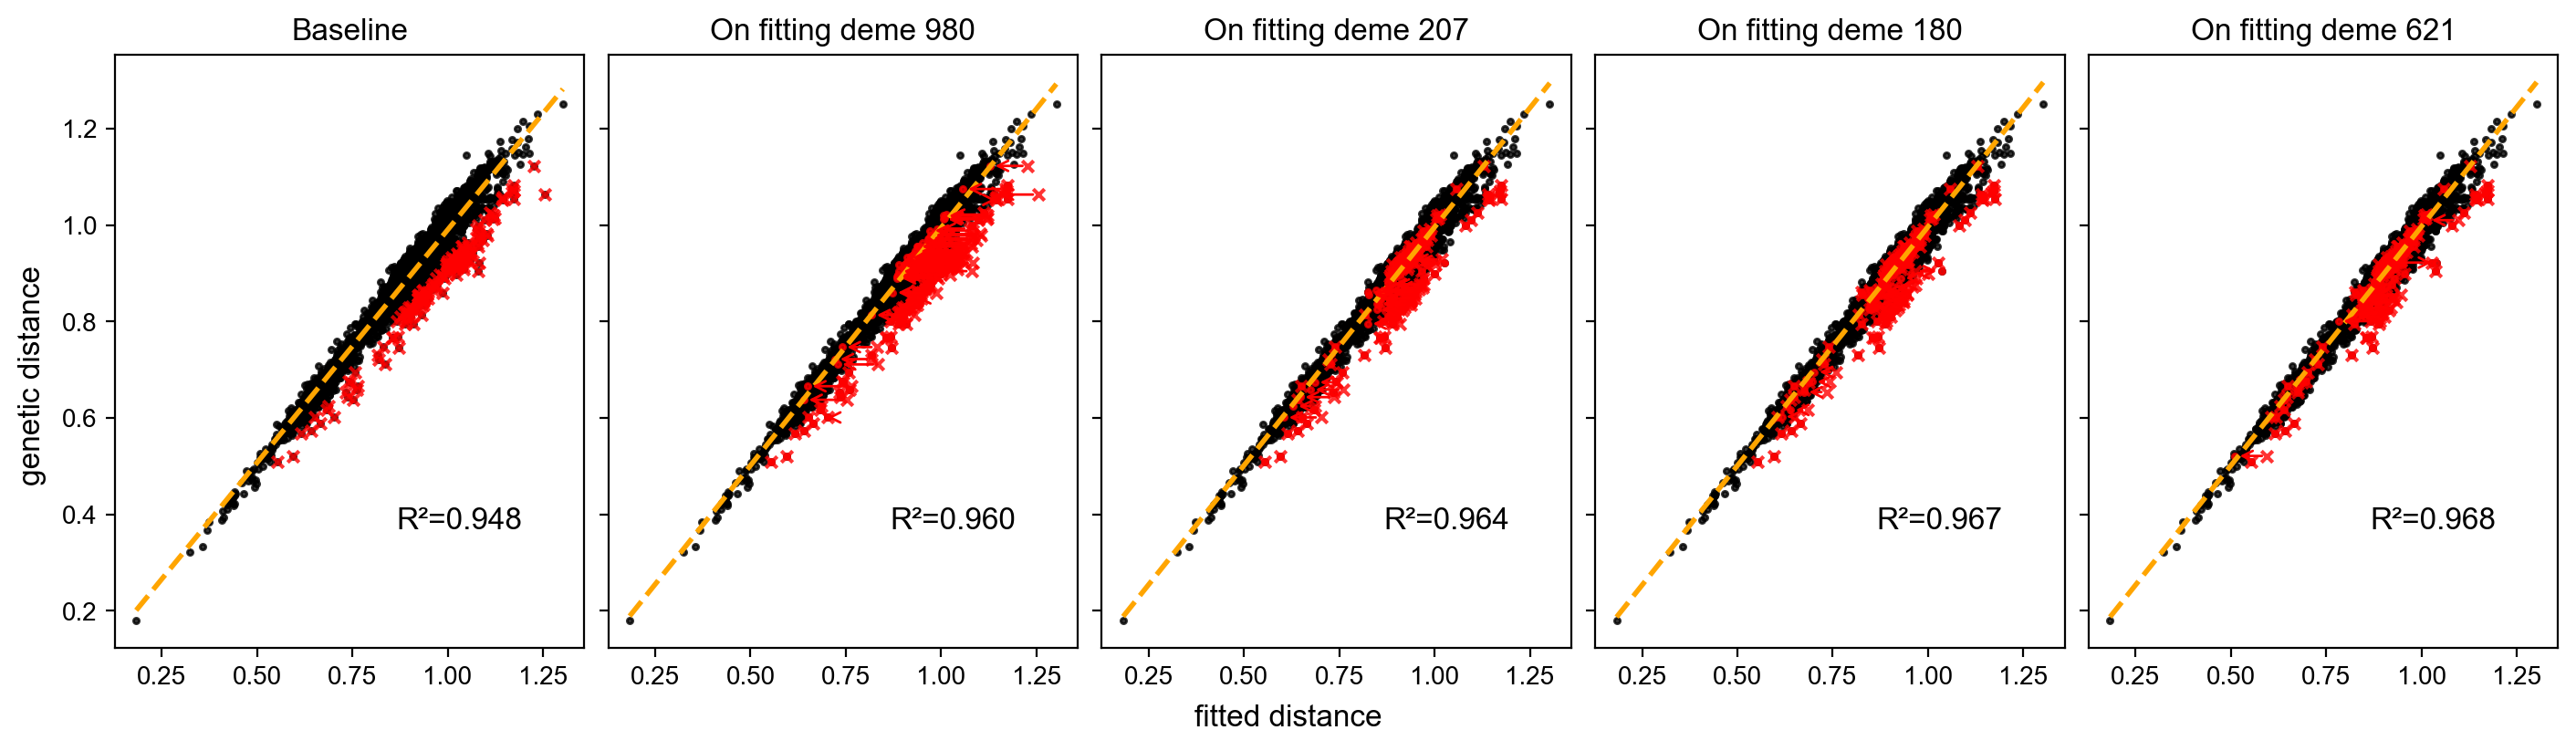

In [307]:
plot_FEEMSmix_result(ind_results, figsize=(14,4))

## Option 2 (`sequential_fit`)

In [60]:
%%time
seq_results = sp_graph.sequential_fit(
    outliers_df, 
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    search_area='all',
    fdr=0.3, # FDR for choosing outliers
    stop=5, # stop after fitting this many edges
    top=0.01 # choose top 1% of most likely demes for joint fit
)

Log-likelihood of initial fit: -34831.0

980     32
621      8
207      6
1206     5
180      4
Name: dest., dtype: int64

Fitting admixture edge to deme 980:
  Optimizing likelihood over 1047 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 11/11 most likely demes in the graph...done!

  Log-likelihood after fitting deme 980: -34463.5
Previous edge to deme 980 significantly increased the log-likelihood.

Using a FDR of 0.3: 110 outlier deme pairs found
Putative destination demes: [ 207  180  621 1206  187  815  834  350  390  402  453  976  617  668
  747  895  189  585]
Deme ID and # of times it was implicated as an outlier:
207     30
180     26
621     16
1206    15
187      8
Name: dest., dtype: int64

Fitting admixture edge to deme 207:
  Optimizing likelihood over 1046 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 5/11 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docsrc/notebooks/../../feems/objective.py:446: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 11/11 most likely demes in the graph...done!

  Log-likelihood after fitting deme 207: -34316.1
Previous edge to deme 207 significantly increased the log-likelihood.

Using a FDR of 0.3: 101 outlier deme pairs found
Putative destination demes: [ 180 1206  621  187  834  585  285  350  815  980  976  895  798  129
  668  453  402  390  189  747  617]
Deme ID and # of times it was implicated as an outlier:
180     30
1206    17
621     16
187     11
585      4
Name: dest., dtype: int64

Fitting admixture edge to deme 180:
  Optimizing likelihood over 1046 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 6/11 most likely demes in the graphWarning: admix. prop. optimization failed (increase atol or factr slightly)
	Jointly optimizing likelihood over 11/11 most likely demes in the graph...done!

  Log-likelihood after fitting deme 180: -34442.1
Previous edge to deme 180 did not significantly increase the log-likelihood at a

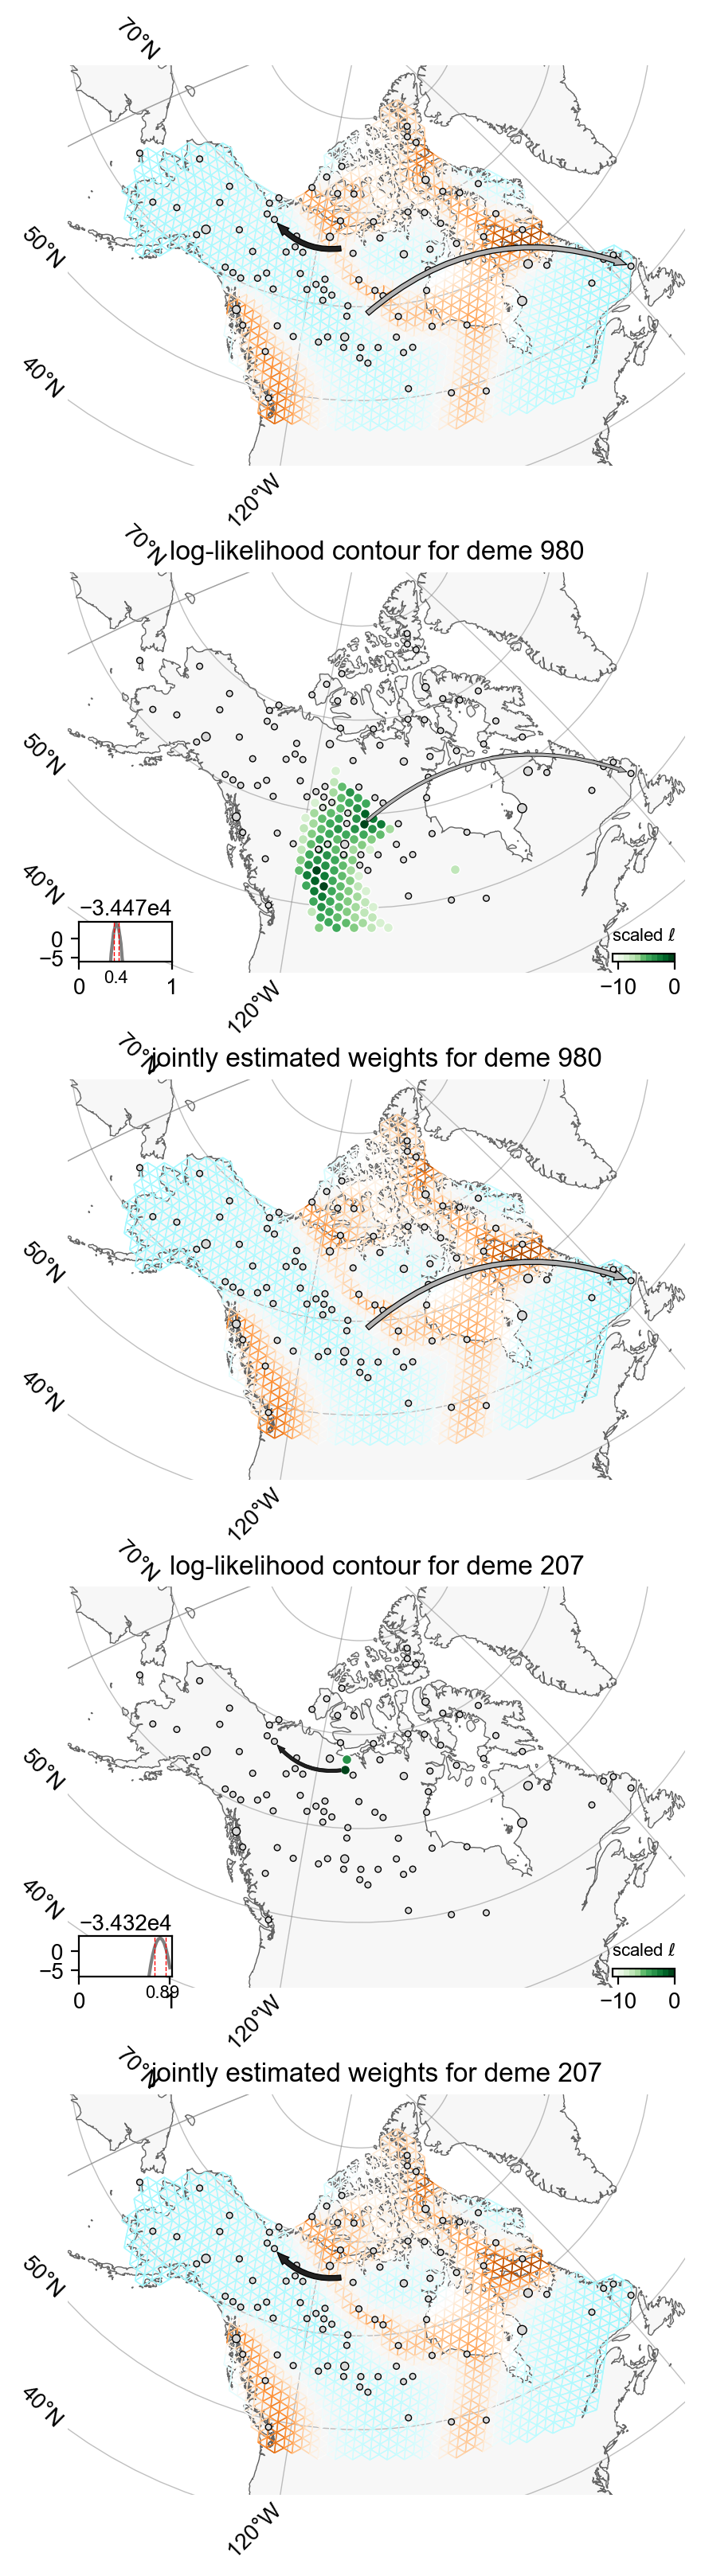

In [68]:
draw_FEEMSmix_fit(
    v, # Viz object created previously
    seq_results, # results from independet_fit above
    magnifier=150, 
    draw_c_contour=False, # draw a contour of admix. prop.?
    draw_edges_mle=True, # draw edge weights after fitting long-range event?
    levels=-10, # how many log-likelihood units to include in plotting
    figsize=(5,20) # increase this size for less crowding 
)
# (optional) save figure in a certain location
# plt.savefig('~/Desktop/wolvesadmix_sequential_fit.pdf')

We observe that the results from the two fits are _almost_ exactly similar, in terms of outlier demes picked, likely source of gene flow and the MLE for the admixture proportion! The key difference being that the `sequential_fit` stops after only adding *two* long-range gene flow events (deme _980_ and _207_), as it finds no more residuals under the model. In both cases, we see that adding adding a long-range edge or gene flow event increases the fit to the observed data.  

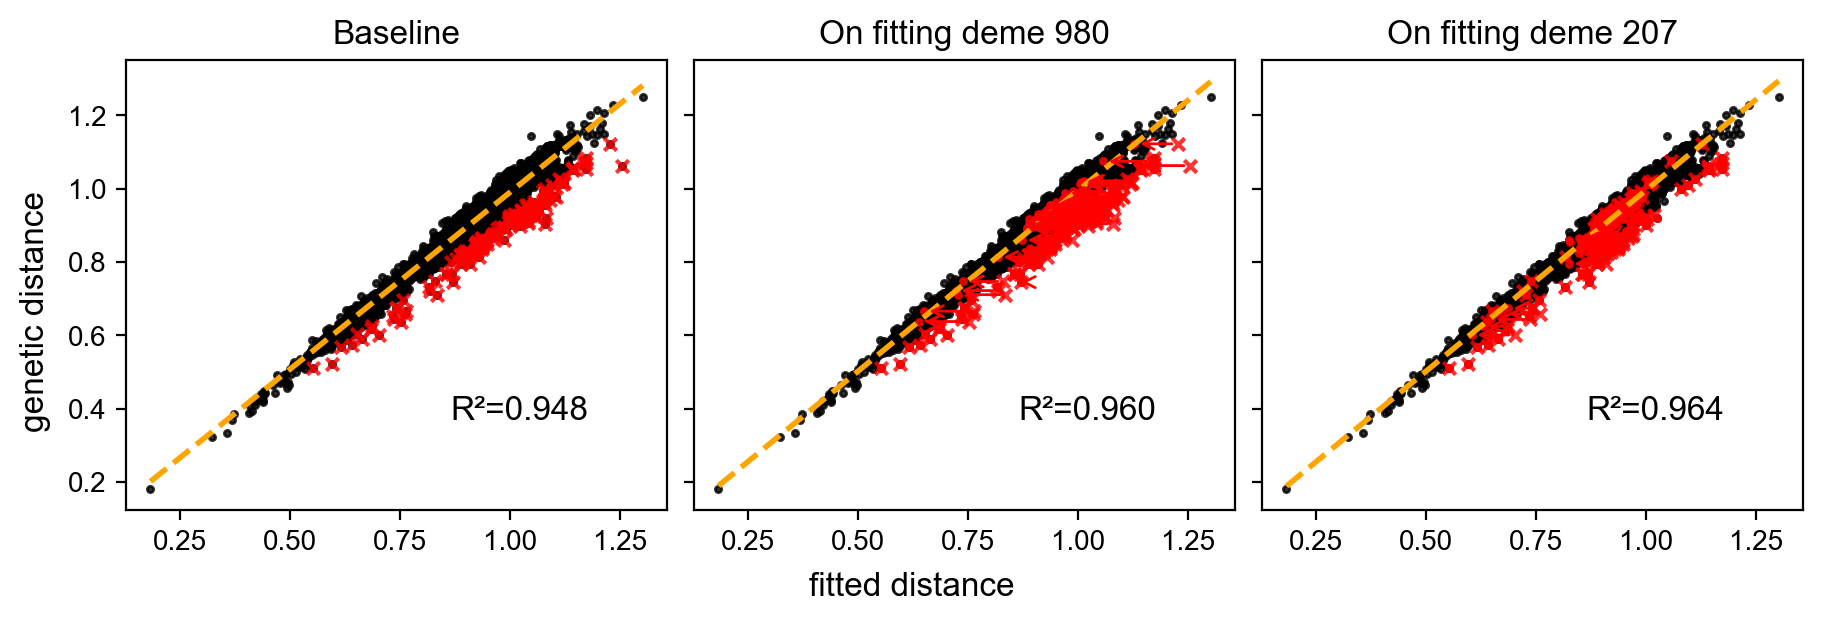

In [249]:
plot_FEEMSmix_result(seq_results, figsize=(9,3))

## Option 3 (pick a particular deme)

We provide this option for flexibility in modeling. Technically, `FEEMSmix` can fit a long-range admixture event to any sampled deme in the grid. There may be cases when the outlier detection scheme might not pick _true_ events in the data, but prior knowledge of the samples might suggest otherwise, so you might want to fit a long-range gene flow event to this deme. 

To show the robustness of the model, we pick two demes that are _not_ implicated by the outlier detection method: deme _976_ and _445_, to demonstrate the performance of the model under a scenario with no known long-range gene flow. Refer to the map above for the location of the two demes. Here

In [31]:
# first stage
df976 = sp_graph.calc_contour(
    destid=976,
)
# second stage
joint_df976 = sp_graph.calc_joint_contour(
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    contour_df=df976, 
    top=0.01,
    search_area='all',
    exclude_boundary=True
)

  Optimizing likelihood over 1046 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 9/21 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docsrc/notebooks/../../feems/objective.py:446: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 21/21 most likely demes in the graph...done!


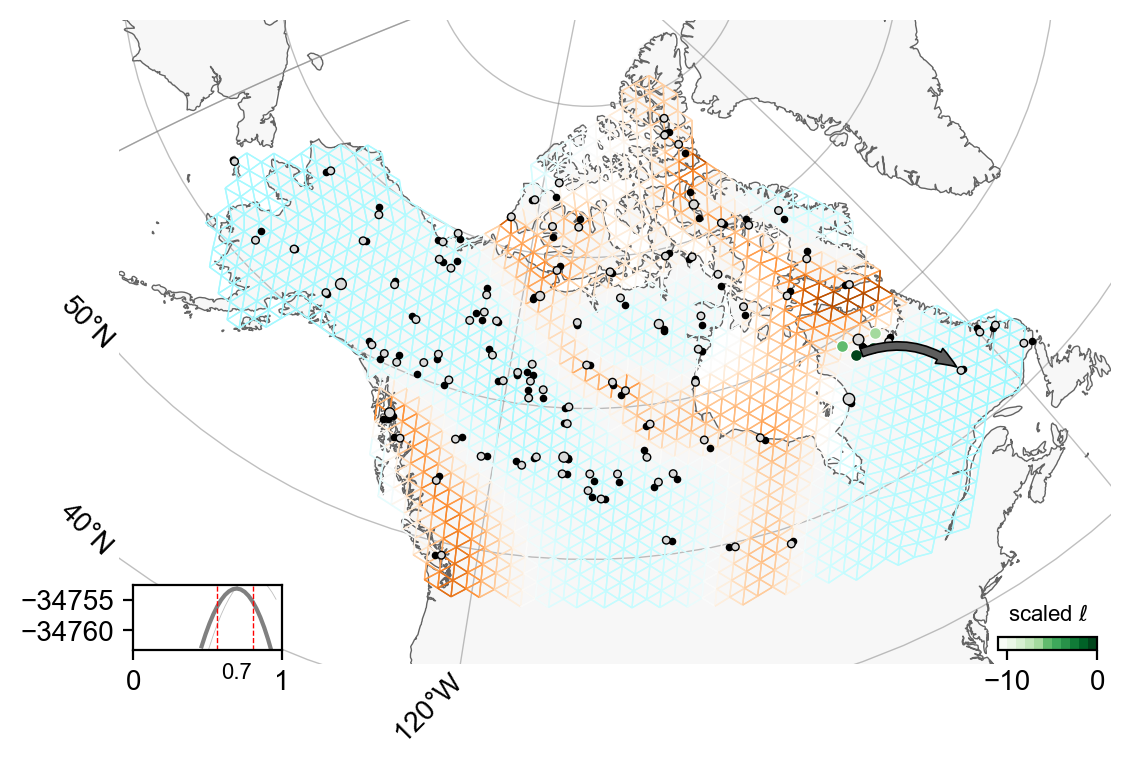

In [34]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); 
v.draw_edges(use_weights=True)
# drawing the contour for deme 976
v.draw_loglik_contour(
    joint_df976, 
    levels=-10,
    magnifier=200
) 
v.draw_samples(); v.draw_obs_nodes(use_ids=False)

For deme _976_, we see that the `FEEMSmix` estimates a "long-range" gene flow event of high $c \approx 0.7$. But, visually, we see that the source for this event is quite close to the putative destination deme _and_ lies within the same migration corridor as the sample in deme _976_, so this probably isn't a "true" long-range gene flow event. This could also be verified via other `admixture`-like analyses. 

Similarly, we can run the same analysis for deme _445_ in British Columbia.

In [298]:
# similarly, with deme 445
df445 = sp_graph.calc_contour(
    destid=445,
)
joint_df445 = sp_graph.calc_joint_contour(
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    contour_df=df445, 
    top=12, 
    exclude_boundary=False,
)

  Optimizing likelihood over 1046 demes in the graph...25%...50%...75%...done!
	Jointly optimizing likelihood over 12/12 most likely demes in the graph...done!


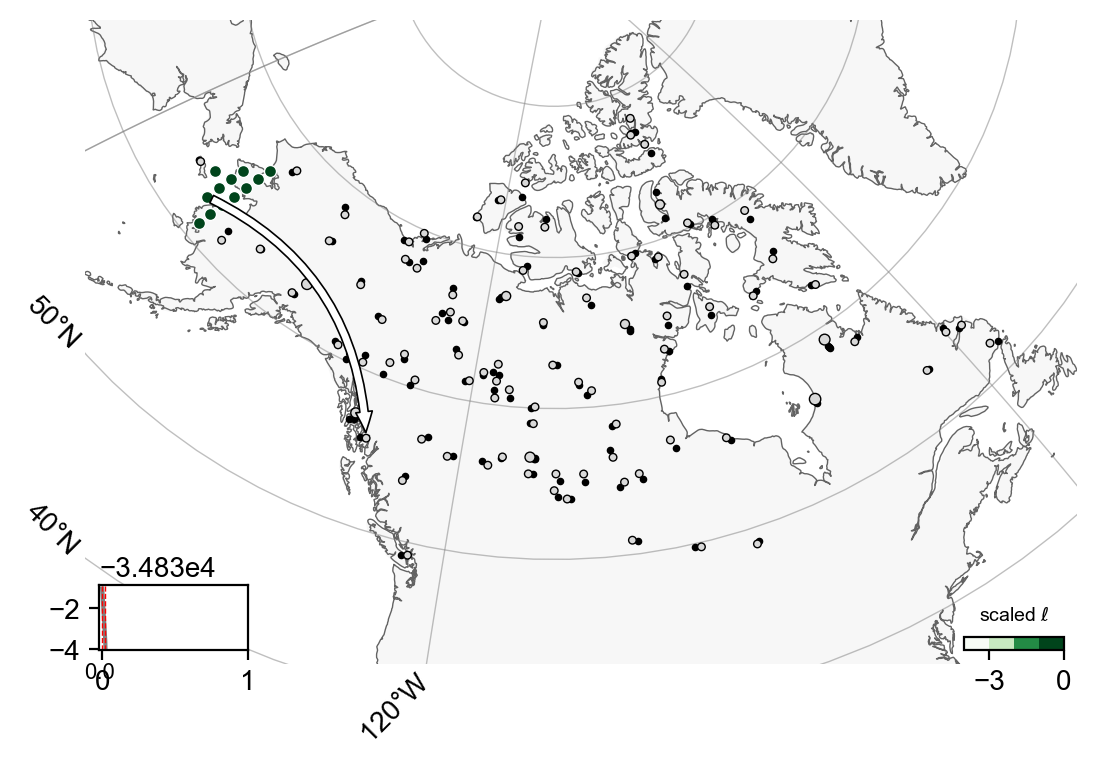

In [288]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); 
# visual trick to keep edges transparent 
v.edge_alpha=0; v.draw_edges(use_weights=False)
# drawing the contour for deme 976
v.draw_loglik_contour(
    joint_df445, 
    levels=-3,
    magnifier=200,
) 
v.draw_samples(); v.draw_obs_nodes(use_ids=False)

Here, we observe a contrasting signal to the previous run. Deme _445_ draws $\approx 0$ admixture from a source in Alaska, signifying a true null event. 

Happy fitting!